# Path Planning On a Grid :: Lazy A* Algorithm

<center><img src="./img/1.png"/></center>


In this lab, we will implement a *Lazy* variant of the `A*` algorithm. The term "Lazy" generally implies that certain computations are postponed until they are absolutely necessary. Specifically, in this lab, we defer *edge evaluations*.

In the standard `A*`, when a node $ s $ is expanded, all its outgoing edges are evaluated. This means we compute the cost of traversing these edges and use these true edge costs to determine the $ g $-values of the successors of $ s $.

Edge evaluations can be time-consuming in some domains. Determining the true cost of an edge might involve complex validation routines, such as collision checking. Therefore, it's practical to evaluate them *lazily*.

To be more precise, when expanding a node $ s $ and generating its successors, we approximate their $ g $-values as:

$$
g(s') = g(s) + cost_{apr}(s,s'),
$$

where $ cost_{apr} $ represents an easily computed conservative estimate of the true cost, meaning $ cost_{apr} \leq cost_{true} $.

We only compute the true cost of the edge $ (s, s') $ when $ s' $ is selected for expansion. This might result in recalculating $ g(s) $ and re-inserting $ s' $ into the Open set.

In summary, this approach can save computation time, as we'll demonstrate in this lab.



In [3]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import math
from heapq import heappop, heappush
from random import randint, random, seed
from time import sleep
from typing import Tuple, List, Iterable, Callable, Type, Dict, Union, Optional
import numpy.typing as npt
import traceback
from textwrap import dedent

%matplotlib inline

## Grid Map Representation 

In [4]:
class Map:
    """
    Represents a square grid environment for our moving agent.

    Attributes
    ----------
    _width : int
        The number of columns in the grid.

    _height : int
        The number of rows in the grid.

    _cells : np.ndarray
        A binary matrix representing the grid where 0 represents a traversable cell, and 1 represents a blocked cell.
    """

    def __init__(self, cells: npt.NDArray):
        """
        Initializes the map using a 2D array of cells.

        Parameters
        ----------
        cells : np.ndarray
            A binary matrix representing the grid. 0 indicates a traversable cell, and 1 indicates a blocked cell.
        """
        self._width = cells.shape[1]
        self._height = cells.shape[0]
        self._cells = cells

    def in_bounds(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is within the grid boundaries.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is inside the grid, False otherwise.
        """
        return 0 <= j < self._width and 0 <= i < self._height

    def traversable(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is not an obstacle.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is traversable, False if it's blocked.
        """
        return not self._cells[i, j]

    def get_neighbors(self, i: int, j: int) -> List[Tuple[int, int]]:
        """
        Gets a list of neighboring cells as (i, j) tuples.
        Assumes that the grid is 8-connected, allowing moves in cardinal and diagonal directions.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        neighbors : List[Tuple[int, int]]
            List of neighboring cells.
        """
        neighbors = []
        delta = ((0, 1), (1, 0), (0, -1), (-1, 0))
        for dx, dy in delta:
            ni, nj = i + dx, j + dy
            if self.in_bounds(ni, nj) and self.traversable(ni, nj):
                neighbors.append((ni, nj))

        delta = [(1, 1), (1, -1), (-1, -1), (-1, 1)]
        for dx, dy in delta:
            ni, nj = i + dx, j + dy
            if (
                self.in_bounds(ni, nj)
                and self.traversable(ni, nj)
                and self.traversable(i, nj)
                and self.traversable(ni, j)
            ):
                neighbors.append((ni, nj))

        return neighbors

    def get_size(self) -> Tuple[int, int]:
        """
        Returns the size of the grid in cells.

        Returns
        ----------
        (height, width) : Tuple[int, int]
            Number of rows and columns in the grid.
        """
        return self._height, self._width

In [5]:
def convert_string_to_cells(cell_str: str) -> npt.NDArray:
    """
    Converts a string representation of a grid map, with '#' for obstacles and '.' for free cells, into a binary matrix.

    Parameters
    ----------
    cell_str : str
        String containing grid map information ('#' for obstacles and '.' for free cells).

    Returns
    ----------
    cells : np.ndarray
        Binary matrix representing the grid map.
    """
    lines = cell_str.replace(" ", "").split("\n")

    cells = np.array(
        [[1 if char == "#" else 0 for char in line] for line in lines if line],
        dtype=np.int8,
    )
    return cells

## Evaluating Edges

The essence of Lazy A* lies in its approach to edge evaluations.

- `compute_cost`: This is the time-consuming function responsible for determining the true cost of an edge, represented as $cost_{true}$.

- `estimate_cost`: A quicker alternative function that provides an approximation or an underestimate of an edge's cost, denoted as $cost_{apr}$.

While the provided implementations of `compute_cost` and `estimate_cost` may seem artificial, they are OK for the purposes of this lab.


In [20]:
def estimate_cost(i1: int, j1: int, i2: int, j2: int):
    """
    Computes the cost of simple moves between cells (i1, j1) and (i2, j2).

    Parameters
    ----------
    i1 : int
        Row number of the first cell in the grid.
    j1 : int
        Column number of the first cell in the grid.
    i2 : int
        Row number of the second cell in the grid.
    j2 : int
        Column number of the second cell in the grid.

    Raises
    ----------
    ValueError
        If trying to compute the cost of a non-supported move.
    """
    d = abs(i1 - i2) + abs(j1 - j2)
    
    if d == 1:  # Cardinal move
        return 1
    elif d == 2:  # Diagonal move
        return math.sqrt(2)
    else:
        raise ValueError("Trying to compute the cost of a non-supported move!")


def compute_cost(i1: int, j1: int, i2: int, j2: int):
    """
    Computes the cost of simple moves between cells (i1, j1) and (i2, j2).

    Parameters
    ----------
    i1 : int
        Row number of the first cell in the grid.
    j1 : int
        Column number of the first cell in the grid.
    i2 : int
        Row number of the second cell in the grid.
    j2 : int
        Column number of the second cell in the grid.

    Raises
    ----------
    ValueError
        If trying to compute the cost of a non-supported move.
    """
    sleep(0.001)  # 1ms sleep to emulate difficult and time-consuming computation of the true cost
    d = abs(i1 - i2) + abs(j1 - j2)
    seed(i1 + j1 + i2 + j2)
    
    if d == 1:  # Cardinal move
        return (
            1 + random()
        )  # Random simulates additional cost that was not taken into account by the estimate_cost method
    elif d == 2:  # Diagonal move
        return math.sqrt(2) + random()
    else:
        raise ValueError("Trying to compute the cost of a non-supported move!")

## Search Node

The structure resembles that of the vanilla `A*`, but with an added twist. We introduce an additional flag, `g_is_true_cost`, to indicate whether the $g$-value of the node was determined using the approximated cost or the true cost.


In [7]:
class Node:
    """
    Represents a search node.

    Attributes
    ----------
    i : int
        Row coordinate of the corresponding grid element.
    j : int
        Column coordinate of the corresponding grid element.
    g : float | int
        g-value of the node.
    h : float | int
        h-value of the node (always 0 for Dijkstra).
    f : float | int
        f-value of the node (always equal to g-value for Dijkstra).
    parent : Node
        Pointer to the parent node.
    g_is_true_cost : bool
        Flag of whether the g-value was precisely computed or has been only estimated.
    """

    def __init__(
        self,
        i: int,
        j: int,
        g: Union[float, int] = 0,
        h: Union[float, int] = 0,
        f: Optional[Union[float, int]] = None,
        parent: "Node" = None,
        g_is_true_cost: bool = False,
    ):
        """
        Initializes a search node.

        Parameters
        ----------
        i : int
            Row coordinate of the corresponding grid element.
        j : int
            Column coordinate of the corresponding grid element.
        g : float | int
            g-value of the node.
        h : float | int
            h-value of the node (always 0 for Dijkstra).
        f : float | int
            f-value of the node (always equal to g-value for Dijkstra).
        parent : Node
            Pointer to the parent node.
        g_is_true_cost : bool
            Flag of whether the g-value was precisely computed or has been only estimated.
        """
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        self.g_is_true_cost = g_is_true_cost
        if f is None:
            self.f = self.g + h
        else:
            self.f = f
        self.parent = parent

    def __eq__(self, other):
        """
        Checks if two search nodes are the same, which is needed to detect duplicates in the search tree.
        """
        return (self.i, self.j) == (other.i, other.j)

    def __hash__(self):
        """
        Makes the Node object hashable, allowing it to be used in sets/dictionaries.
        """
        return hash((self.i, self.j))

    def __lt__(self, other):
        """
        Compares the keys (i.e., the f-values) of two nodes, needed for sorting/extracting the best element from OPEN.
        """
        return self.f < other.f

## Visualization

In [8]:
def draw_rectangle(draw, node, scale, color):
    """Draws a rectangle on the grid, given the node and the desired color."""
    draw.rectangle(
        (
            node.j * scale,
            node.i * scale,
            (node.j + 1) * scale - 1,
            (node.i + 1) * scale - 1,
        ),
        fill=color,
        width=0,
    )


def draw(
    grid_map: Map,
    start: Node = None,
    goal: Node = None,
    path: Iterable[Node] = None,
    nodes_discovered: Iterable[Node] = None,
    nodes_expanded: Iterable[Node] = None,
    edges_evaluated: Dict = None,
):
    """
    Visualizes the environment, path, and expanded/not yet expanded nodes.

    Parameters
    ----------
    grid_map : Map
        Environment represented as a grid.
    start, goal : Optional[Node], Optional[Node]
        Nodes for the start and goal positions of the agent.
    path : Optional[Iterable[Node]]
        Sequence of nodes representing the path between start and goal.
    nodes_discovered : Optional[Iterable[Node]]
        Nodes that were discovered during the search process.
    nodes_expanded : Optional[Iterable[Node]]
        Nodes that were expanded during the search process.
    edges_evaluated : Dict[Tuple[int, int, int, int], bool]]
        This dictionary maps edges (represented as tuples) to boolean values.
        A value of 'True' indicates that the transition for the corresponding edge was accurately calculated.
        A value of 'False' means it was only estimated.
    """
    scale = 16
    height, width = grid_map.get_size()
    im = Image.new("RGB", (width * scale, height * scale), color="white")
    draw = ImageDraw.Draw(im)

    # Draw blocked cells
    for i in range(height):
        for j in range(width):
            if not grid_map.traversable(i, j):
                draw.rectangle(
                    (j * scale, i * scale, (j + 1) * scale - 1, (i + 1) * scale - 1),
                    fill=(70, 80, 80),
                )

    node_colors = [
        (nodes_discovered, (213, 219, 219)),
        (nodes_expanded, (131, 145, 146)),
    ]

    for nodes, color in node_colors:
        if nodes is not None:
            for node in nodes:
                draw_rectangle(draw, node, scale, color)

    if path is not None:
        for step in path:
            color = (52, 152, 219) if grid_map.traversable(step.i, step.j) else (230, 126, 34)
            draw_rectangle(draw, step, scale, color)

    if start is not None and grid_map.traversable(start.i, start.j):
        draw_rectangle(draw, start, scale, (40, 180, 99))

    if goal is not None and grid_map.traversable(goal.i, goal.j):
        draw_rectangle(draw, goal, scale, (231, 76, 60))

    if edges_evaluated is not None:
        for edge in edges_evaluated.keys():
            draw.line(
                ((edge[1] + 0.5) * scale, (edge[0] + 0.5) * scale, (edge[3] + 0.5) * scale, (edge[2] + 0.5) * scale),
                fill=((0, 0, 0) if edges_evaluated[edge] else (200, 200, 200)),
                width=2,
            )

    _, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()

## Implementing the Search Tree

In [9]:
class SearchTreePQD:
    """
    SearchTree using a priority queue for OPEN and a dictionary for CLOSED.
    """

    def __init__(self):
        self._open = []  # Priority queue for nodes in OPEN
        self._closed = dict()  # Dictionary for nodes in CLOSED (expanded nodes)
        self._enc_open_duplicates = 0  # Number of duplicates encountered in OPEN

    def __len__(self) -> int:
        """
        Returns the size of the search tree. Useful for assessing the memory
        footprint of the algorithm, especially at the final iteration.
        """
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        """
        Checks if OPEN is empty.
        If true, the main search loop should be interrupted.
        """
        return len(self._open) == 0

    def add_to_open(self, item: Node):
        """
        Adds a node to the search tree, specifically to OPEN. This node is either
        entirely new or a duplicate of an existing node in OPEN.
        This implementation detects duplicates lazily; thus, nodes are added to
        OPEN without initial duplicate checks.
        """
        heappush(self._open, item)

    def get_best_node_from_open(self) -> Optional[Node]:
        """
        Retrieves the best node from OPEN, defined by the minimum key.
        This node will then be expanded in the main search loop.

        Duplicates are managed here. If a node has been expanded previously
        (and is in CLOSED), it's skipped and the next best node is considered.

        Returns None if OPEN is empty.
        """
        while True:
            if not self._open:
                return None
            
            best_node = heappop(self._open)
            
            if self.was_expanded(best_node): # node was expanded
                self._enc_open_duplicates += 1
                continue

            return best_node

    def add_to_closed(self, item: Node):
        """
        Adds a node to the CLOSED dictionary.
        """
        self._closed[item] = item

    def was_expanded(self, item: Node) -> bool:
        """
        Checks if a node has been previously expanded.
        """
        return item in self._closed

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return self._closed.values()

    @property
    def number_of_open_duplicates(self):
        return self._enc_open_duplicates

## A* Algorithm Without Reexpansions


The input for the `A*` algorithm:

The input is:
- map representation
- start/goal cells
- heuristic function $^*$
- a reference to the implementation of the SearchTree

The output is:
- path found flag (`true` or `false`)
- last node of the path (so one can unwind it using the parent-pointers and get the full path)
- the number of steps (iterations of the main loop)
- the number of nodes that compose the search tree at the final iteration of the algorithm (=the size of the resultant search tree)
- Number of transitions that were precisely computed (representing the number of accurate edge evaluations).
- OPEN and CLOSED (as iterable collections of nodes) for further visualization purposes
- Dictionary representing edges' evaluations. Keys are the node coordinates in the format (i1, j1, i2, j2). A value of True means the transition was precisely computed, and False means it was estimated. 

PS: You might also want to display, at the final iteration, the number of OPEN duplicates encountered during the search, as shown below:

```print("During the search, the following number of OPEN dublicates was encountered: ", ast.number_of_open_duplicates) ```





In [10]:
def diagonal_distance(i1: int, j1: int, i2: int, j2: int) -> float:
    """
    Computes the diagonal (octile) distance between two grid cells.

    Parameters
    ----------
    i1, j1 : int
        Coordinates (i, j) of the first cell on the grid.
    i2, j2 : int
        Coordinates (i, j) of the second cell on the grid.

    Returns
    -------
    float
        The diagonal (octile) distance between the two specified grid cells.
    """
    dx = abs(i1 - i2)
    dy = abs(j1 - j2)
    card_cost = 1
    diag_cost = math.sqrt(2)
    # return card_cost * max(dx, dy) + (diag_cost - card_cost) * min(dx, dy)
    return card_cost * abs(dx - dy) + diag_cost * min(dx, dy)

In [11]:
def astar(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Callable,
    search_tree: Type[SearchTreePQD],
) -> Tuple[
    bool,
    Optional[Node],
    int,
    int,
    int,
    Optional[Iterable[Node]],
    Optional[Iterable[Node]],
    Dict[Tuple[int, int, int, int], bool],
]:
    """
    Implements the A* search algorithm.

    Parameters
    ----------
    task_map : Map
        The grid or map being searched.
    start_i, start_j : int, int
        Starting coordinates.
    goal_i, goal_j : int, int
        Goal coordinates.
    heuristic_func : Callable
        Heuristic function for estimating the distance from a node to the goal.
    search_tree : Type[SearchTreePQD]
        The search tree to use.

    Returns
    -------
    Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]
        Tuple containing:
        - A boolean indicating if a path was found.
        - The last node in the found path or None.
        - Number of algorithm iterations.
        - Size of the resultant search tree.
        - Number of transitions that were precisely computed (representing the number of accurate edge evaluations).
        - OPEN set nodes for visualization or None.
        - CLOSED set nodes.
        - Dictionary representing edges' evaluations. Keys are the node coordinates in the format (i1, j1, i2, j2). A value of True means the transition was precisely computed, and False means it was estimated. Useful for comparing A* with LazyA*.
    """
    ast = search_tree()
    steps = 0

    transitions_computed = 0
    EDGES = {}

    start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j), g_is_true_cost=True)
    ast.add_to_open(start_node)

    while not ast.open_is_empty():
        steps += 1
        current_node = ast.get_best_node_from_open()

        # in lazy impementation we may expand all nodes, but duplicates are still exists
        if current_node is None:
            break
        
        ast.add_to_closed(current_node)
        
        if (current_node.i, current_node.j) == (goal_i, goal_j):
            return True, current_node, steps, len(ast), transitions_computed, ast.opened, ast.expanded, EDGES
        
        for neighbor_i, neighbor_j in task_map.get_neighbors(current_node.i, current_node.j):
            neighbor_g = current_node.g + compute_cost(current_node.i, current_node.j, neighbor_i, neighbor_j)
            neighbor_h = heuristic_func(neighbor_i, neighbor_j, goal_i, goal_j)  
            neighbor_node = Node(neighbor_i, neighbor_j, g=neighbor_g, h=neighbor_h, parent=current_node, g_is_true_cost=True)
            
            if not ast.was_expanded(neighbor_node):
                EDGES[(current_node.i, current_node.j, neighbor_i, neighbor_j)] = True
                transitions_computed += 1
                ast.add_to_open(neighbor_node)

    return False, None, steps, len(ast), transitions_computed, None, ast.expanded, EDGES

## Lazy A* Algorithm

The input and output for the `Lazy A*` algorithm remain consistent with those of the standard `A*`.


In [12]:
def lazy_astar(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Callable,
    search_tree: Type[SearchTreePQD],
) -> Tuple[
    bool,
    Optional[Node],
    int,
    int,
    int,
    Optional[Iterable[Node]],
    Optional[Iterable[Node]],
    Dict[Tuple[int, int, int, int], bool],
]:
    """
    Implements the A* search algorithm.

    Parameters
    ----------
    task_map : Map
        The grid or map being searched.
    start_i, start_j : int, int
        Starting coordinates.
    goal_i, goal_j : int, int
        Goal coordinates.
    heuristic_func : Callable
        Heuristic function for estimating the distance from a node to the goal.
    search_tree : Type[SearchTreePQD]
        The search tree to use.

    Returns
    -------
    Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]
        Tuple containing:
        - A boolean indicating if a path was found.
        - The last node in the found path or None.
        - Number of algorithm iterations.
        - Size of the resultant search tree.
        - Number of transitions that were precisely computed (representing the number of accurate edge evaluations).
        - OPEN set nodes for visualization or None.
        - CLOSED set nodes.
        - Dictionary representing edges' evaluations. Keys are the node coordinates in the format (i1, j1, i2, j2). A value of True means the transition was precisely computed, and False means it was estimated. Useful for comparing A* with LazyA*.
    """
    ast = search_tree()
    steps = 0

    transitions_computed = 0
    EDGES = {}

    start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j), g_is_true_cost=True)
    ast.add_to_open(start_node)

    while not ast.open_is_empty():
        steps += 1
        current_node = ast.get_best_node_from_open()

        # in lazy impementation we may expand all nodes, but duplicates are still exists
        if current_node is None:
            break

        if not current_node.g_is_true_cost:
            parent = current_node.parent
            current_node.g = parent.g + compute_cost(current_node.i, current_node.j, parent.i, parent.j)
            current_node.g_is_true_cost = True
            
            EDGES[(current_node.i, current_node.j, parent.i, parent.j)] = True
            transitions_computed += 1
            
            if current_node.g + current_node.h > current_node.f:
                current_node.f = current_node.g + current_node.h
                ast.add_to_open(current_node)
                continue

        ast.add_to_closed(current_node)
        
        if (current_node.i, current_node.j) == (goal_i, goal_j):
            return True, current_node, steps, len(ast), transitions_computed, ast.opened, ast.expanded, EDGES
        
        for neighbor_i, neighbor_j in task_map.get_neighbors(current_node.i, current_node.j):
            neighbor_g = current_node.g + estimate_cost(current_node.i, current_node.j, neighbor_i, neighbor_j)
            neighbor_h = heuristic_func(neighbor_i, neighbor_j, goal_i, goal_j)  
            neighbor_node = Node(neighbor_i, neighbor_j, g=neighbor_g, h=neighbor_h, parent=current_node, g_is_true_cost=False)

            
            if not ast.was_expanded(neighbor_node):
                EDGES[(current_node.i, current_node.j, neighbor_i, neighbor_j)] = False
                ast.add_to_open(neighbor_node)
        

    return False, None, steps, len(ast), transitions_computed, None, ast.expanded, EDGES

## Validating the results

In [13]:
def make_path(goal: Node) -> Tuple[List[Node], Union[float, int]]:
    """
    Creates a path by tracing parent pointers from the goal node to the start node.
    It also returns the path's length.

    Parameters
    ----------
    goal : Node
        Pointer to the goal node in the search tree.

    Returns
    -------
    Tuple[List[Node], float]
        Path and its length.
    """
    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

When you finish implementing search algorithms, you'll naturally want to test them. The following functions will help you in doing just that.

`simple_test` runs the pathfinding algorithm on a single, straightforward instance. Tests operate under the assumption that the search function follows the pattern below:

```
search(task_map, start.i, start.j, goal.i, goal.j, *optional arguments*) -> (path_found, last_state, steps, search_tree_size, transitions_computed, open, closed, edges)
```

These automated tests anticipate that the search function, which is passed as an input, adheres to the following structure:

- `task_map` is the grid
- `start.i, start.j` are the  $(i, j)$ coordinates of the starting cell
- `goal.i, goal.j` are the $(i, j)$ coordinates of the goal cell
- `*optional arguments*` represent additional parameters of the search function, passed with *args. For instance, the heuristic function.
- `path_found` is `True` if a path was found and `False` otherwise
- `last_state` denotes the last state of the path. It returns `None` if a path was not found
- `steps` provides the number of search steps taken
- `search_tree_size` represents the number of nodes that make up the search tree at the final iteration of the algorithm, which equates to the size of the resultant search tree.
- `transitions_computed` -- the number of transitions that were precisely computed
- `open` is an iterable collection of the nodes that form the search frontier (OPEN nodes)
- `closed` is an iterable collection of the expanded nodes (CLOSED)
-  `edges` is a dictionary representing edges' evaluations. Keys are the node coordinates in the format (i1, j1, i2, j2). A value of True means the transition was precisely computed, and False means it was estimated. 



In [14]:
def simple_test(search_function: Callable, task: Union[int, None], *args):
    """
    Function `simple_test` runs `search_function` on one task. Use a number from 0 to 24 to choose a specific debug task
    on a simple map, or use None to select a random task from this pool. The function displays:
     - 'Path found!' and some statistics if a path was found.
     - 'Path not found!' if a path was not discovered.
     - 'Execution error' if an error occurred during the execution of the search_function.
    In the first case, the function also provides a visualization of the task.

    Parameters
    ----------
    search_function : Callable
        Implementation of the search method.
    task : int | None
        A number from 0 to 24 to choose a specific debug task on a simple map,
        or None to select a random task from this pool.
    *args
        Additional arguments passed to the search function.
    """

    def get_map_data():
        map_str = dedent(
            """
            . . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
            . . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
            . . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
            . . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
            . . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
            . . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
            . . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
            . . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
            . . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
            . . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
        """
        )
        cells = convert_string_to_cells(map_str)
        return Map(cells)

    task_map = get_map_data()
    starts = [(9, 0), (13, 0), (7, 28), (14, 29), (4, 1), (0, 17), (5, 6), (5, 20), (12, 2), (7, 28), (11, 9), (3, 2), (3, 17), (13, 20), (1, 1), (9, 10), (14, 6), (2, 0), (9, 28), (8, 6), (11, 6), (3, 0), (8, 9), (14, 7), (12, 4)]
    goals = [(11, 20), (2, 19), (6, 5), (4, 18), (9, 20), (7, 0), (2, 25), (12, 4), (3, 25), (0, 12), (4, 23), (2, 24), (9, 2), (1, 6), (13, 29), (14, 29), (2, 28), (14, 16), (13, 0), (1, 27), (14, 25), (10, 20), (12, 28), (2, 29), (1, 29)]
    lengths = [40.848, 30.013, 35.294, 20.632, 34.069, 29.416, 38.448, 26.402, 44.959, 24.66, 40.665, 46.738, 29.128, 29.392, 44.189, 37.545, 44.753, 36.602, 44.814, 38.745, 36.396, 34.936, 33.12, 44.632, 44.859]

    if (task is None) or not (0 <= task < 25):
        task = randint(0, 24)

    start = Node(*starts[task])
    goal = Node(*goals[task])
    length = lengths[task]
    try:
        (
            found,
            end_node,
            number_of_steps,
            search_tree_size,
            transitions_computed,
            open_set,
            closed_set,
            edges,
        ) = search_function(task_map, start.i, start.j, goal.i, goal.j, *args)

        expansions = len(closed_set)

        if found:
            path, path_length = make_path(end_node)

            correct = abs(float(path_length) - float(length)) < 0.01
            draw(task_map, start, goal, path, open_set, closed_set, edges)
            print(
                f"Path found! Length: {round(path_length, 3)}. "
                f"Tree size: {search_tree_size}. "
                f"Number of expansions: {expansions}. "
                f"Transitions computed: {transitions_computed}. "
                f"Correct: {correct}."
            )
        else:
            print("Path not found!")
        return

    except Exception as e:
        print(f"Execution error: {e}")
        traceback.print_exc()

## Now Let's Test the Implementation

Executing the next two cells will highlight the behavioral differences between LazyA* and A*. If implemented correctly, LazyA* should perform significantly fewer edge evaluations (roughly half as many in this test) and operate at a notably faster pace.

Feel free to run additional tests by modifying the second argument of the `simple_test` function.

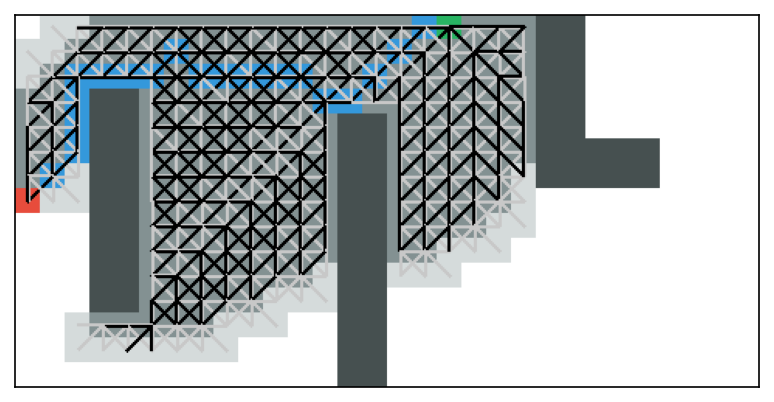

Path found! Length: 29.416. Tree size: 287. Number of expansions: 178. Transitions computed: 350. Correct: True.
CPU times: user 341 ms, sys: 12.9 ms, total: 353 ms
Wall time: 730 ms


In [21]:
%time simple_test(lazy_astar, 5, diagonal_distance, SearchTreePQD)

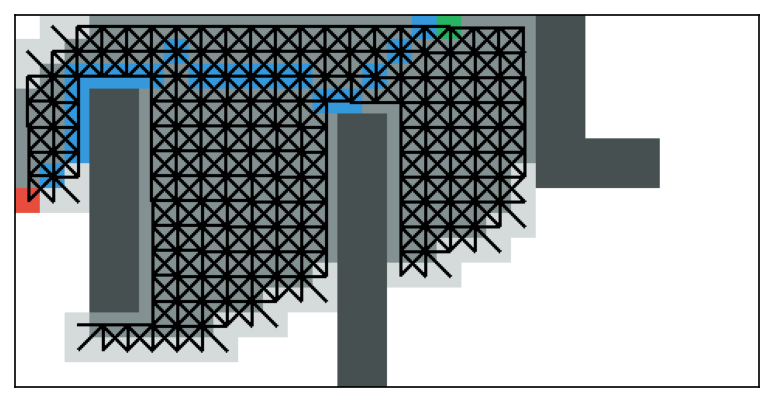

Path found! Length: 29.416. Tree size: 297. Number of expansions: 178. Transitions computed: 656. Correct: True.
CPU times: user 268 ms, sys: 6.29 ms, total: 275 ms
Wall time: 1.59 s


In [22]:
%time simple_test(astar, 5, diagonal_distance, SearchTreePQD)